# Training a ML model using CICIoT2023

This notebook shows how a LogisticRegression model can be trained using the CICIoT2023 csv files.

In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier, Perceptron, RidgeClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, StackingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import joblib
from sklearn.preprocessing import LabelEncoder
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE

In [2]:
DATASET_DIRECTORY = ".\Files\\"

### Importing Dataset

In [3]:
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()
# print(df_sets[0:10])

# Only use the first 10 datasets
# df_sets = df_sets[0:10]

training_sets = df_sets[:int(len(df_sets)*.8)]
test_sets = df_sets[int(len(df_sets)*.8):]

In [4]:
X_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
       'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count',
       'syn_count', 'fin_count', 'urg_count', 'rst_count', 
    'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
       'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
       'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
       'Radius', 'Covariance', 'Variance', 'Weight', 
]
y_column = 'label'

### Scaling

In [5]:
scaler = StandardScaler()

for train_set in tqdm(training_sets):
    scaler.fit(pd.read_csv(DATASET_DIRECTORY + train_set)[X_columns])

100%|██████████| 135/135 [01:39<00:00,  1.35it/s]


## Performance Evaluation

### False positive and false negative function

In [6]:
def calculate_false_positives_and_false_negatives_multiclass_auto(y_true, y_pred):
    """
    Calcule les faux positifs (FP) et les faux négatifs (FN) pour chaque classe dans une classification multiclasse.

    Args:
    - y_true (array-like): Les vraies étiquettes.
    - y_pred (array-like): Les prédictions du modèle.

    Returns:
    - fp_dict (dict): Un dictionnaire contenant les faux positifs par classe.
    - fn_dict (dict): Un dictionnaire contenant les faux négatifs par classe.
    - labels (list): La liste des étiquettes uniques de classe.
    """

    # print(y_true[:5])
    # print(y_pred[:5])
    if y_pred.ndim != 1:
        tableau_1d = y_pred.flatten()

        # Ou utilisez numpy.ravel()
        y_pred = np.ravel(tableau_1d)


    labels = np.unique(np.concatenate([y_true, y_pred]))
    # Créez un dictionnaire pour mapper les étiquettes aux indices entiers
    label_to_index = {label: index for index, label in enumerate(labels)}
    
    fp_dict = {}
    fn_dict = {}
    i = 1

    for label in tqdm(labels):
        # Mapper l'étiquette à l'indice entier
        label_index = label_to_index[label]

        # Créez une matrice de confusion pour la classe actuelle
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        
        # Extrayez les valeurs de faux positifs et de faux négatifs pour la classe actuelle
        fn = sum(cm[i:, label_index])
        temp = cm[label_index, :]
        fp = sum(temp[i:])
        
        fp_dict[label] = fp
        fn_dict[label] = fn

        i += 1

    # # Plot the confusion matrix as a heatmap
    # cm = confusion_matrix(y_true, y_pred, labels=labels)
    # # Normalize the confusion matrix
    # cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
    # plt.figure(figsize=(30, 22))
    # sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', annot_kws={"size": 16})
    # plt.xlabel('Predicted Labels')
    # plt.ylabel('True Labels')
    # plt.title('Confusion Matrix')
    # plt.show()

    data_fp = {
        'Category': list(fp_dict.keys()),
        'Count': list(fp_dict.values())
    }
    df_fp = pd.DataFrame(data_fp)
    df_fp.sort_values(by=['Count'], inplace=True, ascending=False)

    # print(df_fp.head(20))
    fp = df_fp['Count'].sum()

    data_fn = {
        'Category': list(fn_dict.keys()),
        'Count': list(fn_dict.values())
    }
    df_fn = pd.DataFrame(data_fn)
    df_fn.sort_values(by=['Count'], inplace=True, ascending=False)

    # print(df_fn.head(20))
    fn = df_fn['Count'].sum()

    return fp, fn

### Define models and dataframe

In [11]:
# Define the performance dataFrame
simplePerformance = pd.DataFrame(columns=['Accuracy Training', 'Recall Training', 'Precision Training', 'F1 Training', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing', 'FP_rate', 'FN_rate', 'FP', 'FN', 'Total'])
complexPerformance = pd.DataFrame(columns=['Accuracy Training', 'Recall Training', 'Precision Training', 'F1 Training', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing', 'FP_rate', 'FN_rate', 'FP', 'FN', 'Total'])

# Define disctionnairy of correspondant models
simpleModelsDitionnary = [
    {
        "Name": "DT",
        "Model": DecisionTreeClassifier(random_state = 42)
    },
    {
        "Name": "RF",
        "Model": RandomForestClassifier(random_state = 42)
    },
    {
        "Name": "ET",
        "Model": ExtraTreesClassifier(random_state = 42)
    },
    {
        "Name": "XGB",
        "Model": XGBClassifier(random_state = 42)
    },
    # {
    #     "Name": "Cat",
    #     "Model": CatBoostClassifier(random_state = 42, loss_function = 'MultiClass', verbose = 0, boosting_type = 'Plain')
    # },
    # {
    #     "Name": "LIGHT",
    #     "Model": LGBMClassifier(random_state = 42)
    # },
    # {
    #     "Name": "GBoost",
    #     "Model": GradientBoostingClassifier(random_state = 42)
    # },
    # {
    #     "Name": "Adaboost",
    #     "Model": AdaBoostClassifier(random_state = 42)
    # },
    # {
    #     "Name": "MLP",
    #     "Model": MLPClassifier(hidden_layer_sizes = (100,20), max_iter = 300, activation = 'relu', solver = 'adam', random_state = 42)
    # },
    # {
    #     "Name": "HistGradientBoosting",
    #     "Model": HistGradientBoostingClassifier()
    # },
]

complexModelsDitionnary = [
    {
        "Name": "Voting",
        "Model": VotingClassifier([
            ('XGBClassifier', joblib.load('.\\Models\\TUNING\\model_XGB.joblib')),
            ('DecisionTreeClassifier', joblib.load('.\\Models\\TUNING\\model_DT.joblib')),
            ('RandomForestClassifier', joblib.load('.\\Models\\TUNING\\model_RF.joblib')),
            ],
            voting='soft')
    },
    {
        "Name": "Bagging",
        "Model": BaggingClassifier(base_estimator=joblib.load('.\\Models\\TUNING\\model_XGB.joblib'), n_estimators=15)
    },
    {
        "Name": "Stacking",
        "Model": StackingClassifier([
            ('DecisionTreeClassifier', joblib.load('.\\Models\\TUNING\\model_DT.joblib')),
            ('RandomForestClassifier', joblib.load('.\\Models\\TUNING\\model_RF.joblib')),
            ],
            final_estimator=joblib.load('.\\Models\\TUNING\\model_XGB.joblib'),
            cv=5)
    },
]

### Functions for performance 

In [7]:
def singlePerformance(model, X_test, y_test):
    
    y_pred = model.predict(X_test)

    fp, fn = calculate_false_positives_and_false_negatives_multiclass_auto(y_test, y_pred)

    return accuracy_score(y_test, y_pred), recall_score(y_test, y_pred, average='macro'), precision_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='macro'), fp, fn

def mainPerformance(models, df):
    label_encoder = LabelEncoder()
    # smote = SMOTE(random_state=42)

    for model in tqdm(models):
        # Load the train set
        X_train = pd.read_csv(DATASET_DIRECTORY + training_sets[0])[X_columns]
        y_train = pd.read_csv(DATASET_DIRECTORY + training_sets[0])[y_column]

        # Scale the train set
        X_train = scaler.transform(X_train)
        y_train_encoded = label_encoder.fit_transform(y_train)

        # Resample the train set
        # X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)

        # Fit the model
        model["Model"].fit(X_train, y_train_encoded)
        y_pred_train = model["Model"].predict(X_train)

        # Load the test set
        X_test = pd.read_csv(DATASET_DIRECTORY + test_sets[0])[X_columns]
        y_test = pd.read_csv(DATASET_DIRECTORY + test_sets[0])[y_column]

        # Scale the test set
        X_test = scaler.transform(X_test)
        y_test_encoded = label_encoder.transform(y_test)

        # Resample the test set
        # X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test_encoded)

        # Get the performance
        accuracy_train, recall_train, precision_train, f1_train = accuracy_score(y_train_encoded, y_pred_train), recall_score(y_train_encoded, y_pred_train, average='macro'), precision_score(y_train_encoded, y_pred_train, average='macro'), f1_score(y_train_encoded, y_pred_train, average='macro')
        accuracy_testing, recall_testing, precision_testing, f1_testing, fp, fn = singlePerformance(model["Model"], X_test, y_test_encoded)
        df.loc[model["Name"]] = [accuracy_train, recall_train, precision_train, f1_train, accuracy_testing, recall_testing, precision_testing, f1_testing, fp/len(y_test_encoded), fn/len(y_test_encoded), fp, fn, len(y_test_encoded)]
        # performance.loc[model["Name"]] = [accuracy, recall, precision, f1, fp, fn, len(y_test_encoded)]
        # performance = {'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1': f1, 'FP': fp, 'FN': fn, 'Total': len(y_test)}

        # Save model
        joblib.dump(model["Model"], f".\\Models\\PERFORMANCE\\tuning_simple_model_{model['Name']}.joblib")

    return

### Launch

In [13]:
simplePerformance = pd.DataFrame(columns=['Accuracy Training', 'Recall Training', 'Precision Training', 'F1 Training', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing', 'FP_rate', 'FN_rate', 'FP', 'FN', 'Total'])
# simplePerformance.to_csv('.\\Models\\PERFORMANCE\\smote_simplePerformance.csv')

complexPerformance = pd.DataFrame(columns=['Accuracy Training', 'Recall Training', 'Precision Training', 'F1 Training', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing', 'FP_rate', 'FN_rate', 'FP', 'FN', 'Total'])
complexPerformance.to_csv('.\\Models\\PERFORMANCE\\tuning_simple_complexPerformance.csv')

In [16]:
# simplePerformance = pd.read_csv('.\\Models\\PERFORMANCE\\smote_simplePerformance.csv', index_col=0)
# mainPerformance(simpleModelsDitionnary, simplePerformance)
# simplePerformance.to_csv('.\\Models\\PERFORMANCE\\smote_simplePerformance.csv') 
# print(simplePerformance.head(20))

complexPerformance = pd.read_csv('.\\Models\\PERFORMANCE\\tuning_simple_complexPerformance.csv', index_col=0)
mainPerformance(complexModelsDitionnary, complexPerformance)
complexPerformance.to_csv('.\\Models\\PERFORMANCE\\tuning_simple_complexPerformance.csv') 
print(complexPerformance.head(20))

100%|██████████| 3/3 [59:27<00:00, 1189.20s/it]

          Accuracy Training  Recall Training  Precision Training  F1 Training  \
Voting             0.999116         0.982762            0.998932     0.990372   
Bagging            0.999723         0.995741            0.998328     0.997001   
Stacking           0.997340         0.894030            0.984772     0.927305   

          Accuracy Testing  Recall Testing  Precision Testing  F1 Testing  \
Voting            0.994574        0.850900           0.953960    0.882017   
Bagging           0.994498        0.850220           0.943463    0.883143   
Stacking          0.993846        0.846887           0.943662    0.876578   

           FP_rate   FN_rate     FP     FN     Total  
Voting    0.001689  0.003737  404.0  894.0  239203.0  
Bagging   0.001568  0.003934  375.0  941.0  239203.0  
Stacking  0.002270  0.003884  543.0  929.0  239203.0  


### SMOTE Simple performance results

In [11]:
pd.read_csv('.\\Models\\PERFORMANCE\\smote_simplePerformance.csv').sort_values(by=['Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing'], ascending=False).head(20)

,Unnamed: 0,Accuracy Training,Recall Training,Precision Training,F1 Training,Accuracy Testing,Recall Testing,Precision Testing,F1 Testing,FP_rate,FN_rate,FP,FN,Total
3,XGB,0.998004,0.998004,0.998008,0.998004,0.861337,0.861337,0.868364,0.855284,0.054461,0.084202,68401.0,105754.0,1255960.0
0,DT,1.000000,1.000000,1.000000,1.000000,0.834334,0.834334,0.840566,0.828526,0.071863,0.093803,90257.0,117813.0,1255960.0
1,RF,1.000000,1.000000,1.000000,1.000000,0.773429,0.773429,0.785923,0.756127,0.092519,0.134052,116200.0,168364.0,1255960.0
2,ET,1.000000,1.000000,1.000000,1.000000,0.724728,0.724728,0.730320,0.706449,0.103053,0.172219,129431.0,216300.0,1255960.0


### SMOTE Complex performance results

In [10]:
pd.read_csv('.\\Models\\PERFORMANCE\\smote_complexPerformance.csv').sort_values(by=['Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing'], ascending=False).head(20)

,Unnamed: 0,Accuracy Training,Recall Training,Precision Training,F1 Training,Accuracy Testing,Recall Testing,Precision Testing,F1 Testing,FP_rate,FN_rate,FP,FN,Total
1,Bagging,0.998188,0.998188,0.998191,0.998188,0.863353,0.863353,0.868118,0.856839,0.054194,0.082453,68065.0,103558.0,1255960.0
0,Voting,1.000000,1.000000,1.000000,1.000000,0.850948,0.850948,0.856217,0.844907,0.060687,0.088365,76220.0,110983.0,1255960.0
2,Stacking,0.999994,0.999994,0.999994,0.999994,0.742044,0.742044,0.816387,0.718964,0.086542,0.171415,108693.0,215290.0,1255960.0


### Simple performance results

In [12]:
pd.read_csv('.\\Models\\PERFORMANCE\\simplePerformance.csv').sort_values(by=['Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing'], ascending=False).head(20)

,Unnamed: 0,Accuracy Training,Recall Training,Precision Training,F1 Training,Accuracy Testing,Recall Testing,Precision Testing,F1 Testing,FP_rate,FN_rate,FP,FN,Total
3,XGB,0.999979,0.999857,0.999911,0.999884,0.994365,0.851536,0.944877,0.880901,0.001814,0.003821,434.0,914.0,239203.0
0,DT,1.000000,1.000000,1.000000,1.000000,0.991902,0.835225,0.824534,0.825737,0.004197,0.003900,1004.0,933.0,239203.0
1,RF,1.000000,1.000000,1.000000,1.000000,0.991806,0.701688,0.771657,0.708774,0.002479,0.005715,593.0,1367.0,239203.0
4,Cat,0.997696,0.973053,0.992825,0.981896,0.991735,0.713020,0.789654,0.723507,0.002935,0.005330,702.0,1275.0,239203.0
2,ET,1.000000,1.000000,1.000000,1.000000,0.987993,0.685396,0.729531,0.694015,0.003917,0.008089,937.0,1935.0,239203.0
6,GBoost,0.985852,0.686689,0.725083,0.682787,0.985075,0.648145,0.651033,0.641554,0.005715,0.009210,1367.0,2203.0,239203.0
8,MLP,0.986275,0.690842,0.801994,0.707227,0.983600,0.649651,0.690817,0.658087,0.005665,0.010736,1355.0,2568.0,239203.0
9,HistGradientBoosting,0.924877,0.451796,0.455007,0.430397,0.924048,0.446864,0.449786,0.424905,0.043528,0.032424,10412.0,7756.0,239203.0
5,LIGHT,0.582403,0.217012,0.198287,0.187017,0.583366,0.216527,0.196885,0.186656,0.148673,0.267961,35563.0,64097.0,239203.0
7,Adaboost,0.409415,0.362665,0.491495,0.350515,0.407637,0.388987,0.491315,0.372765,0.335673,0.256690,80294.0,61401.0,239203.0


### Complex performance results

In [13]:
pd.read_csv('.\\Models\\PERFORMANCE\\complexPerformance.csv').sort_values(by=['Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing'], ascending=False).head(20)

,Unnamed: 0,Accuracy Training,Recall Training,Precision Training,F1 Training,Accuracy Testing,Recall Testing,Precision Testing,F1 Testing,FP_rate,FN_rate,FP,FN,Total
1,Bagging,0.999560,0.989478,0.997872,0.993416,0.994519,0.842889,0.914111,0.869821,0.001434,0.004047,343.0,968.0,239203.0
0,Voting,1.000000,1.000000,1.000000,1.000000,0.993972,0.843289,0.897316,0.855755,0.002375,0.003654,568.0,874.0,239203.0
2,Stacking,0.999292,0.814850,0.876248,0.820920,0.993290,0.792646,0.882363,0.818658,0.002446,0.004264,585.0,1020.0,239203.0


### Complex performance results with tuning simple models

In [18]:
pd.read_csv('.\\Models\\PERFORMANCE\\tuning_simple_complexPerformance.csv').sort_values(by=['Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing'], ascending=False).head(20)

,Unnamed: 0,Accuracy Training,Recall Training,Precision Training,F1 Training,Accuracy Testing,Recall Testing,Precision Testing,F1 Testing,FP_rate,FN_rate,FP,FN,Total
0,Voting,0.999116,0.982762,0.998932,0.990372,0.994574,0.850900,0.953960,0.882017,0.001689,0.003737,404.0,894.0,239203.0
1,Bagging,0.999723,0.995741,0.998328,0.997001,0.994498,0.850220,0.943463,0.883143,0.001568,0.003934,375.0,941.0,239203.0
2,Stacking,0.997340,0.894030,0.984772,0.927305,0.993846,0.846887,0.943662,0.876578,0.002270,0.003884,543.0,929.0,239203.0


### RF results

100%|██████████| 34/34 [00:00<00:00, 82.97it/s]


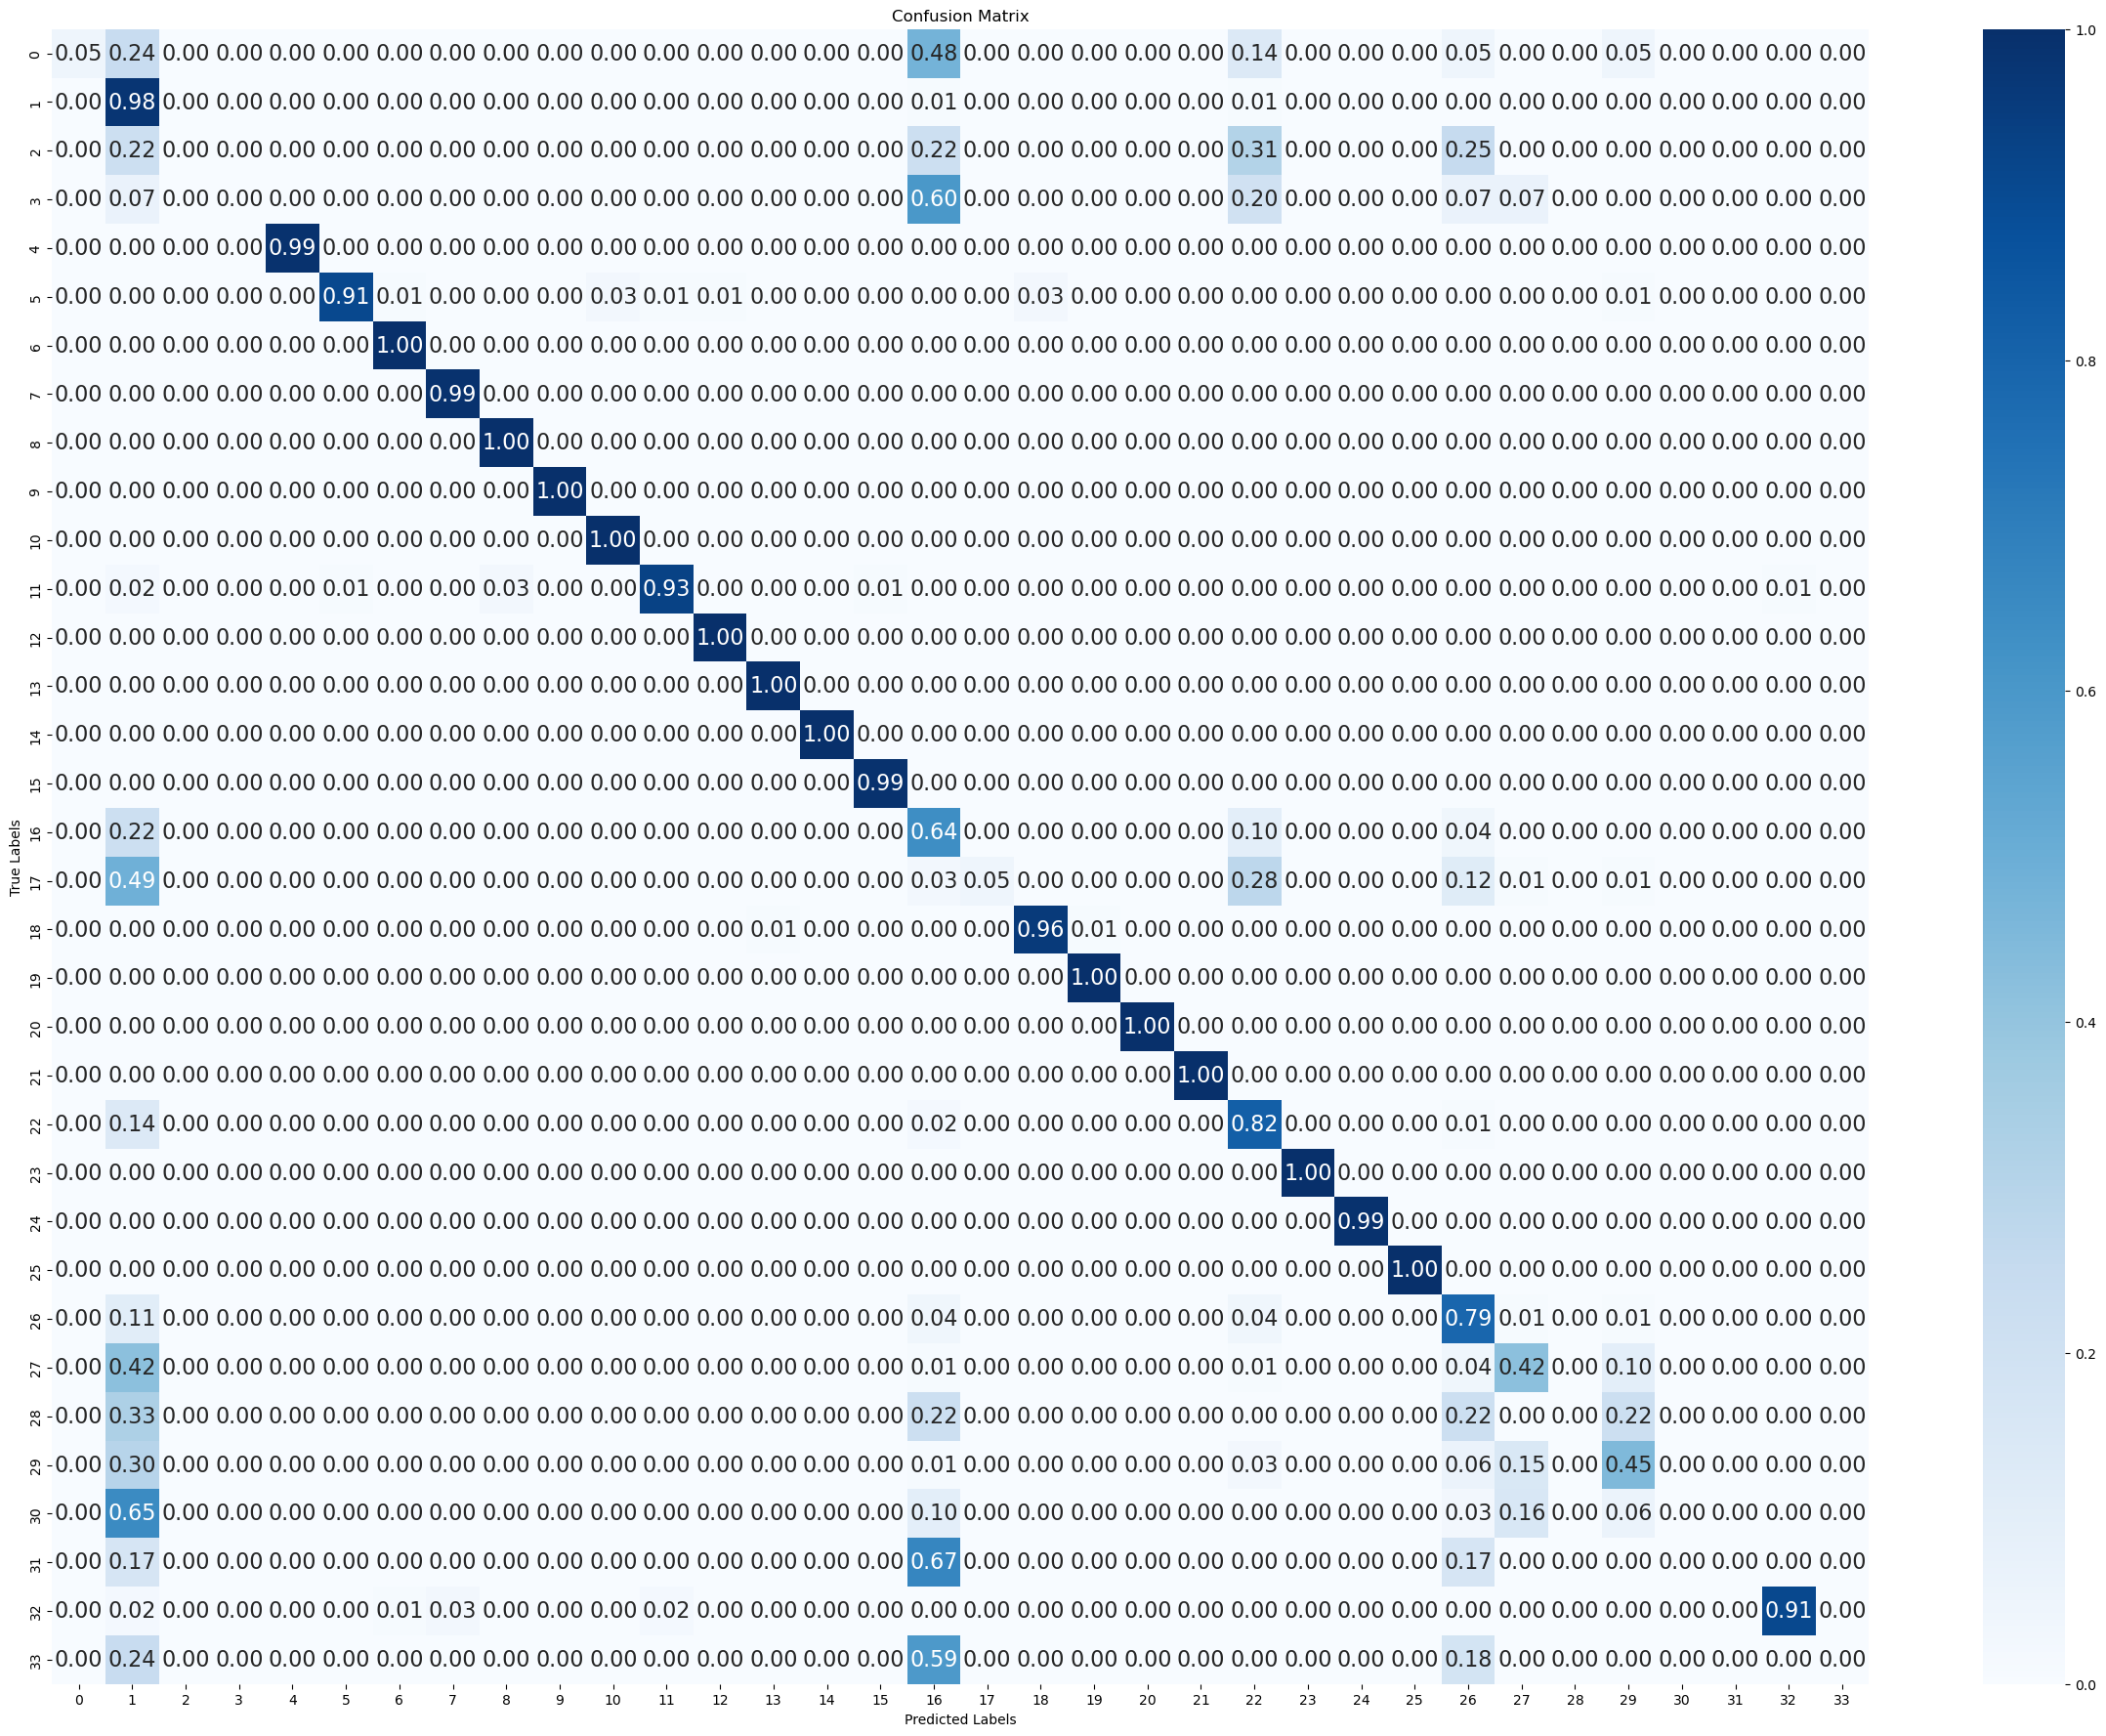

100%|██████████| 1/1 [00:46<00:00, 46.32s/it]


,Accuracy Training,Recall Training,Precision Training,F1 Training,Accuracy Testing,Recall Testing,Precision Testing,F1 Testing,FP_rate,FN_rate,FP,FN,Total
RF,1.0,1.0,1.0,1.0,0.991806,0.701688,0.771657,0.708774,0.002479,0.005715,593.0,1367.0,239203.0


In [24]:
rf_performance = pd.DataFrame(columns=['Accuracy Training', 'Recall Training', 'Precision Training', 'F1 Training', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing', 'FP_rate', 'FN_rate', 'FP', 'FN', 'Total'])
mainPerformance([simpleModelsDitionnary[1]], rf_performance)
rf_performance.head(20)

## Hyperparameter Tuning

#### Functions

In [8]:
def optimize_hyperparameters(model, param_space, X, y):
    """
    Optimise les hyperparamètres du modèle en utilisant la recherche Bayesienne.

    Args:
    - model: Le modèle à optimiser (doit être compatible avec scikit-learn).
    - param_space: L'espace des hyperparamètres à explorer (sous forme de dictionnaire).
    - X: Les caractéristiques d'entraînement.
    - y: Les étiquettes d'entraînement.

    Returns:
    - Le modèle optimisé avec les meilleurs hyperparamètres.
    """

    # Utilisation de la validation croisée stratifiée
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Initialisation de la recherche Bayesienne
    bayes_search = BayesSearchCV(
        model,
        param_space,
        n_iter=10,  # Nombre d'itérations de la recherche Bayesienne
        cv=cv,
        n_jobs=-1,  # Utilisation de tous les cœurs disponibles
        verbose=0,  # Affichage des détails de la recherche
        random_state=42
    )

    # Lancer la recherche Bayesienne
    bayes_search.fit(X, y)

    # Retourner le modèle avec les meilleurs hyperparamètres
    best_model = bayes_search.best_estimator_

    return best_model

def trainModel(model, modelName, param_space, X_train, y_train):
    label_encoder = LabelEncoder()

    # Scale the train set
    X_train = scaler.transform(X_train)
    y_train_encoded = label_encoder.fit_transform(y_train)

    # Optimiser les hyperparamètres du modèle
    best_rf_model = optimize_hyperparameters(model, param_space, X_train, y_train_encoded)

    # Save model
    joblib.dump(best_rf_model, f".\\Models\\TUNING\\model_{modelName}.joblib")

    return best_rf_model

def loadDatasetsTraining(training_set):
    return pd.read_csv(DATASET_DIRECTORY + training_set)[X_columns], pd.read_csv(DATASET_DIRECTORY + training_set)[y_column]

### Simple hyperparameter tuning

#### Launch

In [10]:
# Dictionnaire des modèles à optimiser
hyperparametersSimpleModelsDictionnary = [
    simpleModelsDitionnary[0],
    simpleModelsDitionnary[1],
    simpleModelsDitionnary[3],
]

# Define model-specific parameter spaces
param_space_decision_tree = {
    'max_depth': (1, 20),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),
}

param_space_random_forest = {
    'n_estimators': (10, 200),
    'max_depth': (1, 20),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),
    'max_features': (0.1, 1.0),
}

param_space_xgboost = {
    'n_estimators': (10, 200),
    'max_depth': (1, 20),
    'learning_rate': (0.01, 1.0),
}


# Add model-specific parameter spaces
hyperparametersSimpleModelsDictionnary[0]['param_space'] = param_space_decision_tree
hyperparametersSimpleModelsDictionnary[1]['param_space'] = param_space_random_forest
hyperparametersSimpleModelsDictionnary[2]['param_space'] = param_space_xgboost

In [9]:
for model in tqdm(hyperparametersSimpleModelsDictionnary):
    # Get model informations
    modelName, model, params = model.values()

    # Optimiser les hyperparamètres du modèle
    X_train, y_train = loadDatasetsTraining(training_sets[0])
    trainModel(model, modelName, params, X_train, y_train)

100%|██████████| 1/1 [1:38:04<00:00, 5884.85s/it]


#### Results

In [ ]:
# Define the performance dataFrame
tuningPerformance = pd.DataFrame(columns=['Accuracy Training', 'Recall Training', 'Precision Training', 'F1 Training', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing', 'FP_rate', 'FN_rate', 'FP', 'FN', 'Total'])

for model in tqdm(hyperparametersSimpleModelsDictionnary):
    # Load the model
    best_rf_model = joblib.load(f".\\Models\\TUNING\\model_{model['Name']}.joblib")

    label_encoder = LabelEncoder()

    # Load the train set
    X_train = pd.read_csv(DATASET_DIRECTORY + training_sets[0])[X_columns]
    y_train = pd.read_csv(DATASET_DIRECTORY + training_sets[0])[y_column]

    # Scale the train set
    X_train = scaler.transform(X_train)
    y_train_encoded = label_encoder.fit_transform(y_train)

    # Get the train performance
    y_pred_train = best_rf_model.predict(X_train)

    # Load the test set
    X_test = pd.read_csv(DATASET_DIRECTORY + test_sets[0])[X_columns]
    y_test = pd.read_csv(DATASET_DIRECTORY + test_sets[0])[y_column]

    # Scale the test set
    X_test = scaler.transform(X_test)
    y_test_encoded = label_encoder.transform(y_test)

    # Get train performance
    accuracy_train, recall_train, precision_train, f1_train = accuracy_score(y_train_encoded, y_pred_train), recall_score(y_train_encoded, y_pred_train, average='macro'), precision_score(y_train_encoded, y_pred_train, average='macro'), f1_score(y_train_encoded, y_pred_train, average='macro')

    # Get test performance
    accuracy_testing, recall_testing, precision_testing, f1_testing, fp, fn = singlePerformance(best_rf_model, X_test, y_test_encoded)

    # Add performance to the dataframe
    tuningPerformance.loc[model['Name']] = [accuracy_train, recall_train, precision_train, f1_train, accuracy_testing, recall_testing, precision_testing, f1_testing, fp/len(y_test_encoded), fn/len(y_test_encoded), fp, fn, len(y_test_encoded)]

tuningPerformance.to_csv('.\\Models\\TUNING\\tuningPerformance.csv')
tuningPerformance.head(20)

### Complex hyperparameter tuning

#### Launch

In [9]:
# Dictionnaire des modèles à optimiser
hyperparametersComplexModelsDictionnary = [
    # {
    #     "Name": "Voting",
    #     "Model": VotingClassifier([
    #         ('XGBClassifier', joblib.load('.\\Models\\TUNING\\model_XGB.joblib')),
    #         ('DecisionTreeClassifier', joblib.load('.\\Models\\TUNING\\model_DT.joblib')),
    #         ('RandomForestClassifier', joblib.load('.\\Models\\TUNING\\model_RF.joblib')),
    #         ])
    # },
    {
        "Name": "Bagging",
        "Model": BaggingClassifier(base_estimator=joblib.load('.\\Models\\TUNING\\model_XGB.joblib'))
    },
    {
        "Name": "Stacking",
        "Model": StackingClassifier([
            ('DecisionTreeClassifier', joblib.load('.\\Models\\TUNING\\model_DT.joblib')),
            ('RandomForestClassifier', joblib.load('.\\Models\\TUNING\\model_RF.joblib')),
            ])
    },
]

# Define model-specific parameter spaces
param_space_voting = {
    'voting': ['hard', 'soft'],  # Type de vote (hard ou soft)
    'flatten_transform': [True, False]  # Si les prédictions des modèles doivent être aplaties
}
param_space_bagging = {
    'n_estimators': (10, 200),  # Nombre d'estimateurs dans le BaggingClassifier
    'max_samples': (0.1, 1.0),  # Fraction d'échantillons à utiliser pour chaque estimateur
    'max_features': (0.1, 1.0),  # Fraction de caractéristiques à utiliser pour chaque estimateur
}
param_space_stacking = {
    'stack_method': ['auto', 'predict_proba', 'decision_function'],  # Méthode pour les prédictions empilées
    'n_jobs': [-1]  # Nombre de cœurs CPU à utiliser (-1 pour utiliser tous les cœurs)
}


# Add model-specific parameter spaces
# hyperparametersComplexModelsDictionnary[0]['param_space'] = param_space_voting
hyperparametersComplexModelsDictionnary[0]['param_space'] = param_space_bagging
hyperparametersComplexModelsDictionnary[1]['param_space'] = param_space_stacking

In [10]:
for model in tqdm(hyperparametersComplexModelsDictionnary):
    # Get model informations
    modelName, model, params = model.values()

    # Optimiser les hyperparamètres du modèle
    X_train, y_train = loadDatasetsTraining(training_sets[0])
    trainModel(model, modelName, params, X_train, y_train)

  0%|          | 0/2 [00:00<?, ?it/s]

#### Results

In [ ]:
# Define the performance dataFrame
tuningPerformance = pd.DataFrame(columns=['Accuracy Training', 'Recall Training', 'Precision Training', 'F1 Training', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing', 'FP_rate', 'FN_rate', 'FP', 'FN', 'Total'])
# tuningPerformance = pd.read_csv('.\\Models\\TUNING\\complexTuningPerformance.csv', index_col=0)

for model in tqdm(hyperparametersComplexModelsDictionnary):
    # Load the model
    best_rf_model = joblib.load(f".\\Models\\TUNING\\model_{model['Name']}.joblib")

    label_encoder = LabelEncoder()

    # Load the train set
    X_train = pd.read_csv(DATASET_DIRECTORY + training_sets[0])[X_columns]
    y_train = pd.read_csv(DATASET_DIRECTORY + training_sets[0])[y_column]

    # Scale the train set
    X_train = scaler.transform(X_train)
    y_train_encoded = label_encoder.fit_transform(y_train)

    # Get the train performance
    y_pred_train = best_rf_model.predict(X_train)

    # Load the test set
    X_test = pd.read_csv(DATASET_DIRECTORY + test_sets[0])[X_columns]
    y_test = pd.read_csv(DATASET_DIRECTORY + test_sets[0])[y_column]

    # Scale the test set
    X_test = scaler.transform(X_test)
    y_test_encoded = label_encoder.transform(y_test)

    # Get train performance
    accuracy_train, recall_train, precision_train, f1_train = accuracy_score(y_train_encoded, y_pred_train), recall_score(y_train_encoded, y_pred_train, average='macro'), precision_score(y_train_encoded, y_pred_train, average='macro'), f1_score(y_train_encoded, y_pred_train, average='macro')

    # Get test performance
    accuracy_testing, recall_testing, precision_testing, f1_testing, fp, fn = singlePerformance(best_rf_model, X_test, y_test_encoded)

    # Add performance to the dataframe
    tuningPerformance.loc[model['Name']] = [accuracy_train, recall_train, precision_train, f1_train, accuracy_testing, recall_testing, precision_testing, f1_testing, fp/len(y_test_encoded), fn/len(y_test_encoded), fp, fn, len(y_test_encoded)]

tuningPerformance.to_csv('.\\Models\\TUNING\\complexTuningPerformance.csv')
# tuningPerformance.head(20)

### Simple hyperparameter tuning results

In [14]:
pd.read_csv('.\\Models\\TUNING\\tuningPerformance.csv').sort_values(by=['Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing'], ascending=False).head(20)

,Unnamed: 0,Accuracy Training,Recall Training,Precision Training,F1 Training,Accuracy Testing,Recall Testing,Precision Testing,F1 Testing,FP_rate,FN_rate,FP,FN,Total
2,XGB,0.999996,0.999999,0.999998,0.999998,0.994402,0.856767,0.918675,0.879408,0.001986,0.003612,475.0,864.0,239203.0
1,RF,0.998173,0.955129,0.997747,0.974065,0.994373,0.832556,0.947522,0.866373,0.001380,0.004247,330.0,1016.0,239203.0
0,DT,0.996137,0.880690,0.940203,0.899206,0.992320,0.839000,0.881952,0.842205,0.002617,0.005063,626.0,1211.0,239203.0


### Complex hyperparameter tuning results

In [ ]:
pd.read_csv('.\\Models\\TUNING\\complexTuningPerformance.csv').sort_values(by=['Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing'], ascending=False).head(20)

# Classification: 34 (33+1) classes

In [34]:
ML_models = [
        DecisionTreeClassifier(),
        RandomForestClassifier(n_jobs=-1),
        # GradientBoostingClassifier(),
        # LogisticRegression(n_jobs=-1),
]

ML_neams = [
        "DecisionTreeClassifier",
        "RandomForestClassifier",
        # "GradientBoostingClassifier",
        # "LogisticRegression",
]

# Pour chaque dataset
for train_set in tqdm(training_sets):
    
    # On charge le dataset
    d = pd.read_csv(DATASET_DIRECTORY + train_set)

    # On normalise les données
    d[X_columns] = scaler.transform(d[X_columns])

    print(d[y_column].head())

    # Pour chaque modèle
    for model in (ML_models):

        # On entraîne le modèle
        model.fit(d[X_columns], d[y_column])

    # On supprime le dataset
    del d

  0%|          | 0/135 [00:00<?, ?it/s]

0    DDoS-RSTFINFlood
1       DoS-TCP_Flood
2     DDoS-ICMP_Flood
3       DoS-UDP_Flood
4       DoS-SYN_Flood
Name: label, dtype: object


  0%|          | 0/135 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [127]:
y_test = []
preds = {i:[] for i in range(len(ML_models))}
for test_set in tqdm(test_sets):
    d_test = pd.read_csv(DATASET_DIRECTORY + test_set)
    d_test[X_columns] = scaler.transform(d_test[X_columns])
    
    y_test += list(d_test[y_column].values)
    
    for i in range(len(ML_models)):
        model = ML_models[i]
        y_pred = list(model.predict(d_test[X_columns]))
        preds[i] = preds[i] + y_pred
        

100%|██████████| 2/2 [00:12<00:00,  6.17s/it]


In [128]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
for k,v in preds.items():
    y_pred = v
    print(f"##### {ML_neams[k]} (34 classes) #####")
    print('accuracy_score: ', accuracy_score(y_pred, y_test))
    print('recall_score: ', recall_score(y_pred, y_test, average='macro'))
    print('precision_score: ', precision_score(y_pred, y_test, average='macro'))
    print('f1_score: ', f1_score(y_pred, y_test, average='macro'))
    print()
    print()
    print()

##### DecisionTreeClassifier (34 classes) #####
accuracy_score:  0.9919694984417957
recall_score:  0.8285072816643488
precision_score:  0.8174407816479924
f1_score:  0.8185581953657711



##### RandomForestClassifier (34 classes) #####
accuracy_score:  0.9917859320635604
recall_score:  0.7562229609843071
precision_score:  0.7041411955073251
f1_score:  0.7074143686576185





# Results for classification 34 classes

##### LogisticRegression (34 classes) #####
- accuracy_score:  0.8016639131709932
- recall_score:  0.5854951774651348
- precision_score:  0.48305324146988726
- f1_score:  0.48966648273998686

##### DecisionTreeClassifier (34 classes) #####
- accuracy_score:  0.9920159175259472
- recall_score:  0.8244818441920118
- precision_score:  0.8205782334865411
- f1_score:  0.8200383982988425

##### RandomForestClassifier (34 classes) #####
- accuracy_score:  0.9915897059351019
- recall_score:  0.7620503146664692
- precision_score:  0.7011582842714431
- f1_score:  0.7057468323931881

##### GradientBoostingClassifier (34 classes) #####
- accuracy_score:  0.9888108907611253
- recall_score:  0.7582318098632861
- precision_score:  0.7223169808416247
- f1_score:  0.7231863656996314

##### AdaBoostClassifier (34 classes) #####
- accuracy_score:  0.4407196646010174
- recall_score:  0.41902247243947177
- precision_score:  0.3750765477184141
- f1_score:  0.3265605952381953

##### SGDClassifier (34 classes) #####
- accuracy_score:  0.7886454700248764
- recall_score:  0.5132378715903361
- precision_score:  0.42617099932129565
- f1_score:  0.4299622886448148

##### RidgeClassifier (34 classes) #####
- accuracy_score:  0.7631740525759427
- recall_score:  0.43010389536148935
- precision_score:  0.349978545679562
- f1_score:  0.32991209467439137

##### PassiveAggressiveClassifier (34 classes) #####
- accuracy_score:  0.7758717820497402
- recall_score:  0.509216893964416
- precision_score:  0.4269679598736629
- f1_score:  0.4331352936302771

##### Perceptron (34 classes) #####
- accuracy_score:  0.7359091705120658
- recall_score:  0.49828519884605005
- precision_score:  0.4407204631508492
- f1_score:  0.42571768601861915

##### RidgeClassifierCV (34 classes) #####
- accuracy_score:  0.7631360733252733
- recall_score:  0.4300375882496944
- precision_score:  0.34992014844272346
- f1_score:  0.32990912274049855

# Classification: 8 (7+1) classes

In [129]:
dict_7classes = {}
dict_7classes['DDoS-RSTFINFlood'] = 'DDoS'
dict_7classes['DDoS-PSHACK_Flood'] = 'DDoS'
dict_7classes['DDoS-SYN_Flood'] = 'DDoS'
dict_7classes['DDoS-UDP_Flood'] = 'DDoS'
dict_7classes['DDoS-TCP_Flood'] = 'DDoS'
dict_7classes['DDoS-ICMP_Flood'] = 'DDoS'
dict_7classes['DDoS-SynonymousIP_Flood'] = 'DDoS'
dict_7classes['DDoS-ACK_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-UDP_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-ICMP_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-SlowLoris'] = 'DDoS'
dict_7classes['DDoS-HTTP_Flood'] = 'DDoS'

dict_7classes['DoS-UDP_Flood'] = 'DoS'
dict_7classes['DoS-SYN_Flood'] = 'DoS'
dict_7classes['DoS-TCP_Flood'] = 'DoS'
dict_7classes['DoS-HTTP_Flood'] = 'DoS'


dict_7classes['Mirai-greeth_flood'] = 'Mirai'
dict_7classes['Mirai-greip_flood'] = 'Mirai'
dict_7classes['Mirai-udpplain'] = 'Mirai'

dict_7classes['Recon-PingSweep'] = 'Recon'
dict_7classes['Recon-OSScan'] = 'Recon'
dict_7classes['Recon-PortScan'] = 'Recon'
dict_7classes['VulnerabilityScan'] = 'Recon'
dict_7classes['Recon-HostDiscovery'] = 'Recon'

dict_7classes['DNS_Spoofing'] = 'Spoofing'
dict_7classes['MITM-ArpSpoofing'] = 'Spoofing'

dict_7classes['BenignTraffic'] = 'Benign'

dict_7classes['BrowserHijacking'] = 'Web'
dict_7classes['Backdoor_Malware'] = 'Web'
dict_7classes['XSS'] = 'Web'
dict_7classes['Uploading_Attack'] = 'Web'
dict_7classes['SqlInjection'] = 'Web'
dict_7classes['CommandInjection'] = 'Web'


dict_7classes['DictionaryBruteForce'] = 'BruteForce'

In [130]:
ML_models = [
        # DecisionTreeClassifier(),
        RandomForestClassifier(n_jobs=-1),
        GradientBoostingClassifier(),
        # LogisticRegression(n_jobs=-1),
]

ML_neams = [
        # "DecisionTreeClassifier",
        "RandomForestClassifier",
        "GradientBoostingClassifier",
        # "LogisticRegression",
]


for train_set in tqdm(training_sets):
    d = pd.read_csv(DATASET_DIRECTORY + train_set)
    d[X_columns] = scaler.transform(d[X_columns])
    new_y = [dict_7classes[k] for k in d[y_column]]
    d[y_column] = new_y
    
    for model in (ML_models):
        model.fit(d[X_columns], d[y_column])
    del d

100%|██████████| 8/8 [1:06:06<00:00, 495.85s/it]


In [131]:
y_test = []
preds = {i:[] for i in range(len(ML_models))}
for test_set in tqdm(test_sets):
    d_test = pd.read_csv(DATASET_DIRECTORY + test_set)
    d_test[X_columns] = scaler.transform(d_test[X_columns])
    new_y = [dict_7classes[k] for k in d_test[y_column]]
    d_test[y_column] = new_y
    
    y_test += list(d_test[y_column].values)
    
    for i in range(len(ML_models)):
        model = ML_models[i]
        y_pred = list(model.predict(d_test[X_columns]))
        preds[i] = preds[i] + y_pred
        

100%|██████████| 2/2 [00:13<00:00,  6.85s/it]


In [132]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
for k,v in preds.items():
    y_pred = v
    print(f"##### {ML_neams[k]} (8 classes) #####")
    print('accuracy_score = ', accuracy_score(y_pred, y_test))
    print('recall_score = ', recall_score(y_pred, y_test, average='macro'))
    print('precision_score = ', precision_score(y_pred, y_test, average='macro'))
    print('f1_score = ', f1_score(y_pred, y_test, average='macro'))
    print()
    print()
    print()

##### RandomForestClassifier (8 classes) #####
accuracy_score =  0.9944550294022699
recall_score =  0.8728695527711083
precision_score =  0.7056110449239469
f1_score =  0.7180407251186967



##### GradientBoostingClassifier (8 classes) #####
accuracy_score =  0.9946554754474695
recall_score =  0.9040814776453021
precision_score =  0.818092568562414
f1_score =  0.8473350976774587





# Results for classification 8 classes

##### DecisionTreeClassifier (8 classes) #####
- accuracy_score =  0.9939887286023846
- recall_score =  0.8211775275457525
- precision_score =  0.8234005860868705
- f1_score =  0.8222522645707806

##### RandomForestClassifier (8 classes) #####
- accuracy_score =  0.9944339298185647
- recall_score =  0.9009198371610123
- precision_score =  0.701561593137628
- f1_score =  0.7103702473263263

##### GradientBoostingClassifier (8 classes) #####
- accuracy_score =  0.9946639152809515
- recall_score =  0.9051566339711138
- precision_score =  0.8182008967354992
- f1_score =  0.8478305023003074

##### LogisticRegression (8 classes) #####
- accuracy_score =  0.8314523054460136
- recall_score =  0.8285613319370242
- precision_score =  0.5139777696307017
- f1_score =  0.540448857067295

# Classification: 2 (1+1) Classes

In [133]:
dict_2classes = {}
dict_2classes['DDoS-RSTFINFlood'] = 'Attack'
dict_2classes['DDoS-PSHACK_Flood'] = 'Attack'
dict_2classes['DDoS-SYN_Flood'] = 'Attack'
dict_2classes['DDoS-UDP_Flood'] = 'Attack'
dict_2classes['DDoS-TCP_Flood'] = 'Attack'
dict_2classes['DDoS-ICMP_Flood'] = 'Attack'
dict_2classes['DDoS-SynonymousIP_Flood'] = 'Attack'
dict_2classes['DDoS-ACK_Fragmentation'] = 'Attack'
dict_2classes['DDoS-UDP_Fragmentation'] = 'Attack'
dict_2classes['DDoS-ICMP_Fragmentation'] = 'Attack'
dict_2classes['DDoS-SlowLoris'] = 'Attack'
dict_2classes['DDoS-HTTP_Flood'] = 'Attack'

dict_2classes['DoS-UDP_Flood'] = 'Attack'
dict_2classes['DoS-SYN_Flood'] = 'Attack'
dict_2classes['DoS-TCP_Flood'] = 'Attack'
dict_2classes['DoS-HTTP_Flood'] = 'Attack'


dict_2classes['Mirai-greeth_flood'] = 'Attack'
dict_2classes['Mirai-greip_flood'] = 'Attack'
dict_2classes['Mirai-udpplain'] = 'Attack'

dict_2classes['Recon-PingSweep'] = 'Attack'
dict_2classes['Recon-OSScan'] = 'Attack'
dict_2classes['Recon-PortScan'] = 'Attack'
dict_2classes['VulnerabilityScan'] = 'Attack'
dict_2classes['Recon-HostDiscovery'] = 'Attack'

dict_2classes['DNS_Spoofing'] = 'Attack'
dict_2classes['MITM-ArpSpoofing'] = 'Attack'

dict_2classes['BenignTraffic'] = 'Benign'

dict_2classes['BrowserHijacking'] = 'Attack'
dict_2classes['Backdoor_Malware'] = 'Attack'
dict_2classes['XSS'] = 'Attack'
dict_2classes['Uploading_Attack'] = 'Attack'
dict_2classes['SqlInjection'] = 'Attack'
dict_2classes['CommandInjection'] = 'Attack'

dict_2classes['DictionaryBruteForce'] = 'Attack'

In [134]:
ML_models = [
        # DecisionTreeClassifier(),
        RandomForestClassifier(n_jobs=-1),
        GradientBoostingClassifier(),
        # LogisticRegression(n_jobs=-1),
]

ML_neams = [
        # "DecisionTreeClassifier",
        "RandomForestClassifier",
        "GradientBoostingClassifier",
        # "LogisticRegression",
]


for train_set in tqdm(training_sets):
    d = pd.read_csv(DATASET_DIRECTORY + train_set)
    d[X_columns] = scaler.transform(d[X_columns])
    new_y = [dict_2classes[k] for k in d[y_column]]
    d[y_column] = new_y
    
    for model in (ML_models):
        model.fit(d[X_columns], d[y_column])
    del d

100%|██████████| 8/8 [08:31<00:00, 63.88s/it]


In [135]:
y_test = []
preds = {i:[] for i in range(len(ML_models))}
for test_set in tqdm(test_sets):
    d_test = pd.read_csv(DATASET_DIRECTORY + test_set)
    d_test[X_columns] = scaler.transform(d_test[X_columns])
    new_y = [dict_2classes[k] for k in d_test[y_column]]
    d_test[y_column] = new_y
    
    y_test += list(d_test[y_column].values)
    
    for i in range(len(ML_models)):
        model = ML_models[i]
        y_pred = list(model.predict(d_test[X_columns]))
        preds[i] = preds[i] + y_pred
        

100%|██████████| 2/2 [00:04<00:00,  2.20s/it]


In [136]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
for k,v in preds.items():
    y_pred = v
    print(f"##### {ML_neams[k]} (2 classes) #####")
    print('accuracy_score: ', accuracy_score(y_pred, y_test))
    print('recall_score: ', recall_score(y_pred, y_test, average='macro'))
    print('precision_score: ', precision_score(y_pred, y_test, average='macro'))
    print('f1_score: ', f1_score(y_pred, y_test, average='macro'))
    print()
    print()
    print()

##### GradientBoostingClassifier (2 classes) #####
accuracy_score:  0.9963455521022571
recall_score:  0.9564042322752894
precision_score:  0.9662941895334612
f1_score:  0.9612933295489201



##### LogisticRegression (2 classes) #####
accuracy_score:  0.9888741895122409
recall_score:  0.8922684294547429
precision_score:  0.8609859484895439
f1_score:  0.8759404050008108





# Results for classification 2 classes

##### DecisionTreeClassifier (2 classes) #####
- accuracy_score:  0.995653485756726
- recall_score:  0.9543082158556345
- precision_score:  0.9524318184616076
- f1_score:  0.9533679707468838

##### RandomForestClassifier (2 classes) #####
- accuracy_score:  0.9968013031102896
- recall_score:  0.9654937646506515
- precision_score:  0.9660544448649474
- f1_score:  0.9657739270096768

##### GradientBoostingClassifier (2 classes) #####
- accuracy_score:  0.9963455521022571
- recall_score:  0.9564042322752894
- precision_score:  0.9662941895334612
- f1_score:  0.9612933295489201

##### LogisticRegression (2 classes) #####
- accuracy_score:  0.9888741895122409
- recall_score:  0.8922684294547429
- precision_score:  0.8609859484895439
- f1_score:  0.8759404050008108

# Specific attack model training

In [7]:
# Define the 2 classes for each attack type to create a specific model for each attack type
# DDoS :
dict_2classes_DDoS = {'DDoS-RSTFINFlood': 'DDoS', 'DDoS-PSHACK_Flood': 'DDoS', 'DDoS-SYN_Flood': 'DDoS', 'DDoS-UDP_Flood': 'DDoS', 'DDoS-TCP_Flood': 'DDoS', 'DDoS-ICMP_Flood': 'DDoS', 'DDoS-SynonymousIP_Flood': 'DDoS', 'DDoS-ACK_Fragmentation': 'DDoS', 'DDoS-UDP_Fragmentation': 'DDoS', 'DDoS-ICMP_Fragmentation': 'DDoS', 'DDoS-SlowLoris': 'DDoS', 'DDoS-HTTP_Flood': 'DDoS',
                      'DoS-UDP_Flood': 'Non-DDoS', 'DoS-SYN_Flood': 'Non-DDoS', 'DoS-TCP_Flood': 'Non-DDoS', 'DoS-HTTP_Flood': 'Non-DDoS', 
                      'Mirai-greeth_flood': 'Non-DDoS', 'Mirai-greip_flood': 'Non-DDoS', 'Mirai-udpplain': 'Non-DDoS', 
                      'Recon-PingSweep': 'Non-DDoS', 'Recon-OSScan': 'Non-DDoS', 'Recon-PortScan': 'Non-DDoS', 'VulnerabilityScan': 'Non-DDoS', 'Recon-HostDiscovery': 'Non-DDoS', 
                      'DNS_Spoofing': 'Non-DDoS', 'MITM-ArpSpoofing': 'Non-DDoS', 
                      'BenignTraffic': 'Non-DDoS', 
                      'BrowserHijacking': 'Non-DDoS', 'Backdoor_Malware': 'Non-DDoS', 'XSS': 'Non-DDoS', 'Uploading_Attack': 'Non-DDoS', 'SqlInjection': 'Non-DDoS', 'CommandInjection': 'Non-DDoS', 
                      'DictionaryBruteForce': 'Non-DDoS'}

# DoS :
dict_2classes_DoS = {'DDoS-RSTFINFlood': 'Non-DoS', 'DDoS-PSHACK_Flood': 'Non-DoS', 'DDoS-SYN_Flood': 'Non-DoS', 'DDoS-UDP_Flood': 'Non-DoS', 'DDoS-TCP_Flood': 'Non-DoS', 'DDoS-ICMP_Flood': 'Non-DoS', 'DDoS-SynonymousIP_Flood': 'Non-DoS', 'DDoS-ACK_Fragmentation': 'Non-DoS', 'DDoS-UDP_Fragmentation': 'Non-DoS', 'DDoS-ICMP_Fragmentation': 'Non-DoS', 'DDoS-SlowLoris': 'Non-DoS', 'DDoS-HTTP_Flood': 'Non-DoS',
                      'DoS-UDP_Flood': 'DoS', 'DoS-SYN_Flood': 'DoS', 'DoS-TCP_Flood': 'DoS', 'DoS-HTTP_Flood': 'DoS', 
                      'Mirai-greeth_flood': 'Non-DoS', 'Mirai-greip_flood': 'Non-DoS', 'Mirai-udpplain': 'Non-DoS', 
                      'Recon-PingSweep': 'Non-DoS', 'Recon-OSScan': 'Non-DoS', 'Recon-PortScan': 'Non-DoS', 'VulnerabilityScan': 'Non-DoS', 'Recon-HostDiscovery': 'Non-DoS', 
                      'DNS_Spoofing': 'Non-DoS', 'MITM-ArpSpoofing': 'Non-DoS', 
                      'BenignTraffic': 'Non-DoS', 
                      'BrowserHijacking': 'Non-DoS', 'Backdoor_Malware': 'Non-DoS', 'XSS': 'Non-DoS', 'Uploading_Attack': 'Non-DoS', 'SqlInjection': 'Non-DoS', 'CommandInjection': 'Non-DoS', 
                      'DictionaryBruteForce': 'Non-DoS'}

# Mirai :
dict_2classes_Mirai = {'DDoS-RSTFINFlood': 'Non-Mirai', 'DDoS-PSHACK_Flood': 'Non-Mirai', 'DDoS-SYN_Flood': 'Non-Mirai', 'DDoS-UDP_Flood': 'Non-Mirai', 'DDoS-TCP_Flood': 'Non-Mirai', 'DDoS-ICMP_Flood': 'Non-Mirai', 'DDoS-SynonymousIP_Flood': 'Non-Mirai', 'DDoS-ACK_Fragmentation': 'Non-Mirai', 'DDoS-UDP_Fragmentation': 'Non-Mirai', 'DDoS-ICMP_Fragmentation': 'Non-Mirai', 'DDoS-SlowLoris': 'Non-Mirai', 'DDoS-HTTP_Flood': 'Non-Mirai',
                      'DoS-UDP_Flood': 'Non-Mirai', 'DoS-SYN_Flood': 'Non-Mirai', 'DoS-TCP_Flood': 'Non-Mirai', 'DoS-HTTP_Flood': 'Non-Mirai', 
                      'Mirai-greeth_flood': 'Mirai', 'Mirai-greip_flood': 'Mirai', 'Mirai-udpplain': 'Mirai', 
                      'Recon-PingSweep': 'Non-Mirai', 'Recon-OSScan': 'Non-Mirai', 'Recon-PortScan': 'Non-Mirai', 'VulnerabilityScan': 'Non-Mirai', 'Recon-HostDiscovery': 'Non-Mirai', 
                      'DNS_Spoofing': 'Non-Mirai', 'MITM-ArpSpoofing': 'Non-Mirai', 
                      'BenignTraffic': 'Non-Mirai', 
                      'BrowserHijacking': 'Non-Mirai', 'Backdoor_Malware': 'Non-Mirai', 'XSS': 'Non-Mirai', 'Uploading_Attack': 'Non-Mirai', 'SqlInjection': 'Non-Mirai', 'CommandInjection': 'Non-Mirai', 
                      'DictionaryBruteForce': 'Non-Mirai'}

# Recon :
dict_2classes_Recon = {'DDoS-RSTFINFlood': 'Non-Recon', 'DDoS-PSHACK_Flood': 'Non-Recon', 'DDoS-SYN_Flood': 'Non-Recon', 'DDoS-UDP_Flood': 'Non-Recon', 'DDoS-TCP_Flood': 'Non-Recon', 'DDoS-ICMP_Flood': 'Non-Recon', 'DDoS-SynonymousIP_Flood': 'Non-Recon', 'DDoS-ACK_Fragmentation': 'Non-Recon', 'DDoS-UDP_Fragmentation': 'Non-Recon', 'DDoS-ICMP_Fragmentation': 'Non-Recon', 'DDoS-SlowLoris': 'Non-Recon', 'DDoS-HTTP_Flood': 'Non-Recon',
                      'DoS-UDP_Flood': 'Non-Recon', 'DoS-SYN_Flood': 'Non-Recon', 'DoS-TCP_Flood': 'Non-Recon', 'DoS-HTTP_Flood': 'Non-Recon', 
                      'Mirai-greeth_flood': 'Non-Recon', 'Mirai-greip_flood': 'Non-Recon', 'Mirai-udpplain': 'Non-Recon', 
                      'Recon-PingSweep': 'Recon', 'Recon-OSScan': 'Recon', 'Recon-PortScan': 'Recon', 'VulnerabilityScan': 'Recon', 'Recon-HostDiscovery': 'Recon', 
                      'DNS_Spoofing': 'Non-Recon', 'MITM-ArpSpoofing': 'Non-Recon', 
                      'BenignTraffic': 'Non-Recon', 
                      'BrowserHijacking': 'Non-Recon', 'Backdoor_Malware': 'Non-Recon', 'XSS': 'Non-Recon', 'Uploading_Attack': 'Non-Recon', 'SqlInjection': 'Non-Recon', 'CommandInjection': 'Non-Recon', 
                      'DictionaryBruteForce': 'Non-Recon'}

# Spoofing :
dict_2classes_Spoofing = {'DDoS-RSTFINFlood': 'Non-Spoofing', 'DDoS-PSHACK_Flood': 'Non-Spoofing', 'DDoS-SYN_Flood': 'Non-Spoofing', 'DDoS-UDP_Flood': 'Non-Spoofing', 'DDoS-TCP_Flood': 'Non-Spoofing', 'DDoS-ICMP_Flood': 'Non-Spoofing', 'DDoS-SynonymousIP_Flood': 'Non-Spoofing', 'DDoS-ACK_Fragmentation': 'Non-Spoofing', 'DDoS-UDP_Fragmentation': 'Non-Spoofing', 'DDoS-ICMP_Fragmentation': 'Non-Spoofing', 'DDoS-SlowLoris': 'Non-Spoofing', 'DDoS-HTTP_Flood': 'Non-Spoofing',
                      'DoS-UDP_Flood': 'Non-Spoofing', 'DoS-SYN_Flood': 'Non-Spoofing', 'DoS-TCP_Flood': 'Non-Spoofing', 'DoS-HTTP_Flood': 'Non-Spoofing', 
                      'Mirai-greeth_flood': 'Non-Spoofing', 'Mirai-greip_flood': 'Non-Spoofing', 'Mirai-udpplain': 'Non-Spoofing', 
                      'Recon-PingSweep': 'Non-Spoofing', 'Recon-OSScan': 'Non-Spoofing', 'Recon-PortScan': 'Non-Spoofing', 'VulnerabilityScan': 'Non-Spoofing', 'Recon-HostDiscovery': 'Non-Spoofing', 
                      'DNS_Spoofing': 'Spoofing', 'MITM-ArpSpoofing': 'Spoofing', 
                      'BenignTraffic': 'Non-Spoofing', 
                      'BrowserHijacking': 'Non-Spoofing', 'Backdoor_Malware': 'Non-Spoofing', 'XSS': 'Non-Spoofing', 'Uploading_Attack': 'Non-Spoofing', 'SqlInjection': 'Non-Spoofing', 'CommandInjection': 'Non-Spoofing', 
                      'DictionaryBruteForce': 'Non-Spoofing'}

# Benign :
dict_2classes_Benign = {'DDoS-RSTFINFlood': 'Non-Benign', 'DDoS-PSHACK_Flood': 'Non-Benign', 'DDoS-SYN_Flood': 'Non-Benign', 'DDoS-UDP_Flood': 'Non-Benign', 'DDoS-TCP_Flood': 'Non-Benign', 'DDoS-ICMP_Flood': 'Non-Benign', 'DDoS-SynonymousIP_Flood': 'Non-Benign', 'DDoS-ACK_Fragmentation': 'Non-Benign', 'DDoS-UDP_Fragmentation': 'Non-Benign', 'DDoS-ICMP_Fragmentation': 'Non-Benign', 'DDoS-SlowLoris': 'Non-Benign', 'DDoS-HTTP_Flood': 'Non-Benign',
                      'DoS-UDP_Flood': 'Non-Benign', 'DoS-SYN_Flood': 'Non-Benign', 'DoS-TCP_Flood': 'Non-Benign', 'DoS-HTTP_Flood': 'Non-Benign', 
                      'Mirai-greeth_flood': 'Non-Benign', 'Mirai-greip_flood': 'Non-Benign', 'Mirai-udpplain': 'Non-Benign', 
                      'Recon-PingSweep': 'Non-Benign', 'Recon-OSScan': 'Non-Benign', 'Recon-PortScan': 'Non-Benign', 'VulnerabilityScan': 'Non-Benign', 'Recon-HostDiscovery': 'Non-Benign', 
                      'DNS_Spoofing': 'Non-Benign', 'MITM-ArpSpoofing': 'Non-Benign', 
                      'BenignTraffic': 'Benign', 
                      'BrowserHijacking': 'Non-Benign', 'Backdoor_Malware': 'Non-Benign', 'XSS': 'Non-Benign', 'Uploading_Attack': 'Non-Benign', 'SqlInjection': 'Non-Benign', 'CommandInjection': 'Non-Benign', 
                      'DictionaryBruteForce': 'Non-Benign'}

# Web :
dict_2classes_Web = {'DDoS-RSTFINFlood': 'Non-Web', 'DDoS-PSHACK_Flood': 'Non-Web', 'DDoS-SYN_Flood': 'Non-Web', 'DDoS-UDP_Flood': 'Non-Web', 'DDoS-TCP_Flood': 'Non-Web', 'DDoS-ICMP_Flood': 'Non-Web', 'DDoS-SynonymousIP_Flood': 'Non-Web', 'DDoS-ACK_Fragmentation': 'Non-Web', 'DDoS-UDP_Fragmentation': 'Non-Web', 'DDoS-ICMP_Fragmentation': 'Non-Web', 'DDoS-SlowLoris': 'Non-Web', 'DDoS-HTTP_Flood': 'Non-Web',
                      'DoS-UDP_Flood': 'Non-Web', 'DoS-SYN_Flood': 'Non-Web', 'DoS-TCP_Flood': 'Non-Web', 'DoS-HTTP_Flood': 'Non-Web', 
                      'Mirai-greeth_flood': 'Non-Web', 'Mirai-greip_flood': 'Non-Web', 'Mirai-udpplain': 'Non-Web', 
                      'Recon-PingSweep': 'Non-Web', 'Recon-OSScan': 'Non-Web', 'Recon-PortScan': 'Non-Web', 'VulnerabilityScan': 'Non-Web', 'Recon-HostDiscovery': 'Non-Web', 
                      'DNS_Spoofing': 'Non-Web', 'MITM-ArpSpoofing': 'Non-Web', 
                      'BenignTraffic': 'Non-Web', 
                      'BrowserHijacking': 'Web', 'Backdoor_Malware': 'Web', 'XSS': 'Web', 'Uploading_Attack': 'Web', 'SqlInjection': 'Web', 'CommandInjection': 'Web', 
                      'DictionaryBruteForce': 'Non-Web'}

# BruteForce :
dict_2classes_BruteForce = {'DDoS-RSTFINFlood': 'Non-BruteForce', 'DDoS-PSHACK_Flood': 'Non-BruteForce', 'DDoS-SYN_Flood': 'Non-BruteForce', 'DDoS-UDP_Flood': 'Non-BruteForce', 'DDoS-TCP_Flood': 'Non-BruteForce', 'DDoS-ICMP_Flood': 'Non-BruteForce', 'DDoS-SynonymousIP_Flood': 'Non-BruteForce', 'DDoS-ACK_Fragmentation': 'Non-BruteForce', 'DDoS-UDP_Fragmentation': 'Non-BruteForce', 'DDoS-ICMP_Fragmentation': 'Non-BruteForce', 'DDoS-SlowLoris': 'Non-BruteForce', 'DDoS-HTTP_Flood': 'Non-BruteForce',
                      'DoS-UDP_Flood': 'Non-BruteForce', 'DoS-SYN_Flood': 'Non-BruteForce', 'DoS-TCP_Flood': 'Non-BruteForce', 'DoS-HTTP_Flood': 'Non-BruteForce', 
                      'Mirai-greeth_flood': 'Non-BruteForce', 'Mirai-greip_flood': 'Non-BruteForce', 'Mirai-udpplain': 'Non-BruteForce', 
                      'Recon-PingSweep': 'Non-BruteForce', 'Recon-OSScan': 'Non-BruteForce', 'Recon-PortScan': 'Non-BruteForce', 'VulnerabilityScan': 'Non-BruteForce', 'Recon-HostDiscovery': 'Non-BruteForce', 
                      'DNS_Spoofing': 'Non-BruteForce', 'MITM-ArpSpoofing': 'Non-BruteForce', 
                      'BenignTraffic': 'Non-BruteForce', 
                      'BrowserHijacking': 'Non-BruteForce', 'Backdoor_Malware': 'Non-BruteForce', 'XSS': 'Non-BruteForce', 'Uploading_Attack': 'Non-BruteForce', 'SqlInjection': 'Non-BruteForce', 'CommandInjection': 'Non-BruteForce', 
                      'DictionaryBruteForce': 'BruteForce'}

dict_2classes = [{"dict_2classes": dict_2classes_DDoS, "type": "DDoS"}, {"dict_2classes": dict_2classes_DoS, "type": "DoS"}, {"dict_2classes": dict_2classes_Mirai, "type": "Mirai"}, {"dict_2classes": dict_2classes_Recon, "type": "Recon"}, {"dict_2classes": dict_2classes_Spoofing, "type": "Spoofing"}, {"dict_2classes": dict_2classes_Benign, "type": "Benign"}, {"dict_2classes": dict_2classes_Web, "type": "Web"}, {"dict_2classes": dict_2classes_BruteForce, "type": "BruteForce"}]
print(dict_2classes[0])

{'dict_2classes': {'DDoS-RSTFINFlood': 'DDoS', 'DDoS-PSHACK_Flood': 'DDoS', 'DDoS-SYN_Flood': 'DDoS', 'DDoS-UDP_Flood': 'DDoS', 'DDoS-TCP_Flood': 'DDoS', 'DDoS-ICMP_Flood': 'DDoS', 'DDoS-SynonymousIP_Flood': 'DDoS', 'DDoS-ACK_Fragmentation': 'DDoS', 'DDoS-UDP_Fragmentation': 'DDoS', 'DDoS-ICMP_Fragmentation': 'DDoS', 'DDoS-SlowLoris': 'DDoS', 'DDoS-HTTP_Flood': 'DDoS', 'DoS-UDP_Flood': 'Non-DDoS', 'DoS-SYN_Flood': 'Non-DDoS', 'DoS-TCP_Flood': 'Non-DDoS', 'DoS-HTTP_Flood': 'Non-DDoS', 'Mirai-greeth_flood': 'Non-DDoS', 'Mirai-greip_flood': 'Non-DDoS', 'Mirai-udpplain': 'Non-DDoS', 'Recon-PingSweep': 'Non-DDoS', 'Recon-OSScan': 'Non-DDoS', 'Recon-PortScan': 'Non-DDoS', 'VulnerabilityScan': 'Non-DDoS', 'Recon-HostDiscovery': 'Non-DDoS', 'DNS_Spoofing': 'Non-DDoS', 'MITM-ArpSpoofing': 'Non-DDoS', 'BenignTraffic': 'Non-DDoS', 'BrowserHijacking': 'Non-DDoS', 'Backdoor_Malware': 'Non-DDoS', 'XSS': 'Non-DDoS', 'Uploading_Attack': 'Non-DDoS', 'SqlInjection': 'Non-DDoS', 'CommandInjection': 'Non-

In [8]:
ML_models = [
        DecisionTreeClassifier(),
        # RandomForestClassifier(n_jobs=-1),
        # GradientBoostingClassifier(),
        # LogisticRegression(n_jobs=-1),
]

ML_neams = [
        "DecisionTreeClassifier",
        # "RandomForestClassifier",
        # "GradientBoostingClassifier",
        # "LogisticRegression",
]

# Itération sur chaque objet du dictionnaire
for dict_item in dict_2classes:
        print(f"##### {dict_item['type']} (2 classes) #####")
        print()
        print()
        # Extraire le dictionnaire dict_2classes et le type associé
        dict_2classes = dict_item["dict_2classes"]
        type_name = dict_item["type"]

        # For each dataset
        for train_set in tqdm(training_sets):
        
                # Load the dataset in memory
                d = pd.read_csv(DATASET_DIRECTORY + train_set)

                # Normalize the data
                d[X_columns] = scaler.transform(d[X_columns])

                # Update the labels of the target variable
                new_y = [dict_2classes[k] for k in d[y_column]]
                d[y_column] = new_y
                
                # For each model
                for model in (ML_models):

                        # Train the model
                        model.fit(d[X_columns], d[y_column])

                # Delete the dataset from memory
                del d

        # Initialisation d'une liste pour stocker les vraies valeurs de la variable cible (classe) pour l'ensemble de test.
        y_test = []

        # Initialisation d'un dictionnaire pour stocker les prédictions de chaque modèle.
        # Les clés du dictionnaire sont les indices des modèles.
        preds = {i: [] for i in range(len(ML_models))}

        # Itération sur chaque ensemble de test contenu dans la liste test_sets.
        for test_set in tqdm(test_sets):
                # Chargement d'un fichier CSV correspondant à l'ensemble de test actuel dans un DataFrame pandas d_test.
                d_test = pd.read_csv(DATASET_DIRECTORY + test_set)

                # Mise à l'échelle des colonnes d'entités de d_test à l'aide d'un objet scaler.
                # Cela permet de mettre à l'échelle les données de test de la même manière que les données d'entraînement.
                d_test[X_columns] = scaler.transform(d_test[X_columns])

                # Création d'une nouvelle liste new_y en associant chaque valeur de d_test[y_column]
                # aux valeurs correspondantes dans le dictionnaire dict_2classes.
                # Cela permet de mapper les étiquettes d'origine aux classes utilisées pour l'évaluation.
                new_y = [dict_2classes[k] for k in d_test[y_column]]

                # Remplacement de la colonne de la variable cible y_column dans d_test par les nouvelles étiquettes new_y.
                d_test[y_column] = new_y

                # Extension de la liste y_test avec les valeurs de la variable cible transformée pour l'ensemble de test actuel.
                y_test += list(d_test[y_column].values)

                # Itération sur chaque modèle contenu dans la liste ML_models.
                for i in range(len(ML_models)):
                        # Sélection du modèle actuel à évaluer.
                        model = ML_models[i]

                        # Utilisation du modèle pour faire des prédictions sur l'ensemble de test actuel.
                        y_pred = list(model.predict(d_test[X_columns]))
                        
                        # Stockage des prédictions du modèle actuel dans la liste correspondante du dictionnaire preds.
                        preds[i] = preds[i] + y_pred

        # Initialize the list of true labels
        for k,v in preds.items():
                # Save model
                joblib.dump(ML_models[k], f".\Models\model_{ML_neams[k]}_{dict_item['type']}.joblib")

                y_pred = v
                print(f"##### {ML_neams[k]} {dict_item['type']} (2 classes) #####")
                print('accuracy_score: ', accuracy_score(y_pred, y_test))
                print('recall_score: ', recall_score(y_pred, y_test, average='macro'))
                print('precision_score: ', precision_score(y_pred, y_test, average='macro'))
                print('f1_score: ', f1_score(y_pred, y_test, average='macro'))
                print()
                print()
                print()


##### DDoS (2 classes) #####




100%|██████████| 34/34 [00:47<00:00,  1.39s/it]


##### DecisionTreeClassifier DDoS (2 classes) #####
accuracy_score:  0.9995984588634549
recall_score:  0.9994938784073801
precision_score:  0.999492544786964
f1_score:  0.9994932115945829



##### DoS (2 classes) #####




100%|██████████| 34/34 [00:46<00:00,  1.38s/it]


##### DecisionTreeClassifier DoS (2 classes) #####
accuracy_score:  0.9998533871958086
recall_score:  0.999734935392105
precision_score:  0.9997534472254663
f1_score:  0.9997441910222378



##### Mirai (2 classes) #####




100%|██████████| 34/34 [00:47<00:00,  1.39s/it]


##### DecisionTreeClassifier Mirai (2 classes) #####
accuracy_score:  0.9999609290416271
recall_score:  0.9998077545615813
precision_score:  0.9998254662909732
f1_score:  0.9998166102481232



##### Recon (2 classes) #####




100%|██████████| 34/34 [00:47<00:00,  1.40s/it]


##### DecisionTreeClassifier Recon (2 classes) #####
accuracy_score:  0.9969604922012336
recall_score:  0.8999832346191019
precision_score:  0.8981810623023343
f1_score:  0.8990800783175715



##### Spoofing (2 classes) #####




100%|██████████| 34/34 [00:47<00:00,  1.39s/it]


##### DecisionTreeClassifier Spoofing (2 classes) #####
accuracy_score:  0.9962889359266263
recall_score:  0.9057595694217162
precision_score:  0.9169927923623553
f1_score:  0.9112976416738859



##### Benign (2 classes) #####




100%|██████████| 34/34 [00:46<00:00,  1.38s/it]


##### DecisionTreeClassifier Benign (2 classes) #####
accuracy_score:  0.9957698917840835
recall_score:  0.9534527451598984
precision_score:  0.9546202621998258
f1_score:  0.9540357131744854



##### Web (2 classes) #####




100%|██████████| 34/34 [00:46<00:00,  1.38s/it]


##### DecisionTreeClassifier Web (2 classes) #####
accuracy_score:  0.9993841488541619
recall_score:  0.7114222214878461
precision_score:  0.7366239492943202
f1_score:  0.7233130349957493



##### BruteForce (2 classes) #####




100%|██████████| 34/34 [00:51<00:00,  1.51s/it]


##### DecisionTreeClassifier BruteForce (2 classes) #####
accuracy_score:  0.9997076447842543
recall_score:  0.7471431943606167
precision_score:  0.7960909409847152
f1_score:  0.7694098832870624





# Test

In [231]:
ML_models = [
        DecisionTreeClassifier(),
        # RandomForestClassifier(n_jobs=-1),
        # GradientBoostingClassifier(),
        # LogisticRegression(n_jobs=-1),
]

ML_neams = [
        "DecisionTreeClassifier",
        # "RandomForestClassifier",
        # "GradientBoostingClassifier",
        # "LogisticRegression",
]

# Load last model
# modelName = "DecisionTreeClassifier"
# loaded_model = joblib.load(f".\Models\model_{modelName}_DDoS.joblib")
# ML_models.append(loaded_model)
# ML_neams.append(modelName)

# For each dataset
for train_set in tqdm(training_sets):
    
    # Load the dataset in memory
    d = pd.read_csv(DATASET_DIRECTORY + train_set)

    # Normalize the data
    d[X_columns] = scaler.transform(d[X_columns])

    # Update the labels of the target variable
    new_y = [dict_2classes[k] for k in d[y_column]]
    d[y_column] = new_y
    
    # For each model
    for model in (ML_models):

        # Train the model
        model.fit(d[X_columns], d[y_column])

    # Delete the dataset from memory
    del d

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
<class 'sklearn.tree._classes.DecisionTreeClassifier'>
<class 'sklearn.tree._classes.DecisionTreeClassifier'>


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:44<00:00,  5.53s/it]


In [232]:
# Initialisation d'une liste pour stocker les vraies valeurs de la variable cible (classe) pour l'ensemble de test.
y_test = []

# Initialisation d'un dictionnaire pour stocker les prédictions de chaque modèle.
# Les clés du dictionnaire sont les indices des modèles.
preds = {i: [] for i in range(len(ML_models))}

# Itération sur chaque ensemble de test contenu dans la liste test_sets.
for test_set in tqdm(test_sets):
    # Chargement d'un fichier CSV correspondant à l'ensemble de test actuel dans un DataFrame pandas d_test.
    d_test = pd.read_csv(DATASET_DIRECTORY + test_set)
    
    # Mise à l'échelle des colonnes d'entités de d_test à l'aide d'un objet scaler.
    # Cela permet de mettre à l'échelle les données de test de la même manière que les données d'entraînement.
    d_test[X_columns] = scaler.transform(d_test[X_columns])

    # Création d'une nouvelle liste new_y en associant chaque valeur de d_test[y_column]
    # aux valeurs correspondantes dans le dictionnaire dict_2classes.
    # Cela permet de mapper les étiquettes d'origine aux classes utilisées pour l'évaluation.
    new_y = [dict_2classes[k] for k in d_test[y_column]]
    
    # Remplacement de la colonne de la variable cible y_column dans d_test par les nouvelles étiquettes new_y.
    d_test[y_column] = new_y
    
    # Extension de la liste y_test avec les valeurs de la variable cible transformée pour l'ensemble de test actuel.
    y_test += list(d_test[y_column].values)
    
    # Itération sur chaque modèle contenu dans la liste ML_models.
    for i in range(len(ML_models)):
        # Sélection du modèle actuel à évaluer.
        model = ML_models[i]

        # Utilisation du modèle pour faire des prédictions sur l'ensemble de test actuel.
        y_pred = list(model.predict(d_test[X_columns]))
        
        # Stockage des prédictions du modèle actuel dans la liste correspondante du dictionnaire preds.
        preds[i] = preds[i] + y_pred


100%|██████████| 2/2 [00:03<00:00,  1.80s/it]


In [233]:
# Initialize the list of true labels
for k,v in preds.items():
    # Save model
    joblib.dump(ML_models[k], f".\Models\model_{ML_neams[k]}_DDoS.joblib")

    y_pred = v
    print(f"##### {ML_neams[k]} (2 classes) #####")
    print('accuracy_score: ', accuracy_score(y_pred, y_test))
    print('recall_score: ', recall_score(y_pred, y_test, average='macro'))
    print('precision_score: ', precision_score(y_pred, y_test, average='macro'))
    print('f1_score: ', f1_score(y_pred, y_test, average='macro'))
    print()
    print()
    print()

##### DecisionTreeClassifier (2 classes) #####
accuracy_score:  0.9996729564525692
recall_score:  0.9995829511618257
precision_score:  0.9995902588168041
f1_score:  0.9995866049119663



##### DecisionTreeClassifier (2 classes) #####
accuracy_score:  0.999656076785605
recall_score:  0.9995324226102099
precision_score:  0.9995981775667151
f1_score:  0.9995652938243755





# Results for classification DDoS

##### DecisionTreeClassifier (2 classes) #####
- accuracy_score:  0.999656076785605
- recall_score:  0.9995397188023061
- precision_score:  0.9995908637100563
- f1_score:  0.9995652874666482

##### RandomForestClassifier (2 classes) #####
- accuracy_score:  0.9995421390335969
- recall_score:  0.9993835583640872
- precision_score:  0.9994590309032679
- f1_score:  0.999421286377896

##### GradientBoostingClassifier (2 classes) #####
- accuracy_score:  0.9996138776181946
- recall_score:  0.9995253081576231
- precision_score:  0.9994985147827335
- f1_score:  0.9995119104302792

##### LogisticRegression (2 classes) #####
- accuracy_score:  0.8466566654639904
- recall_score:  0.8835917015235932
- precision_score:  0.7278965042927341
- f1_score:  0.7636924766683586

# Memory cleanning 

In [52]:
import gc
gc.collect()

0